# How to Build an Autoencoder Using Keras and TensorFlow

**Subtitle**: How to build an autoencoder for image compression, image reconstruction and supervised learning using the TensorFlow library

**Summary**: You can easily build an autoencoder using objects and APIs from the Keras and TensorFlow library. Here are the basics of what you need to know to build your own autoencoder.

**Byline**: Mehreen Saeed 

An autoencoder has two parts: an encoder and a decoder. The encoder learns a latent representation of the input data and the decoder is trained to reconstruct the original inputs from the latent representations. The autoencoder has the following applications.

- An autoencoder approximates the original input points from the latent representations. This makes it useful for data recovery from corrupt inputs. 
- As the autoencoder learns a latent representation of the input data, it can be designed so that the dimensions of this latent space is much smaller than the original input dimensions. Hence, an autoencoder can be used for data compression.
- Autoencoders find their application for data augmentation. The outputs from the autoencoder represent synthetic data and hence, can be added to the original training set to increase its size.
- The latent representation from an autoencoder can be used to learn classification and regression tasks.

In this article we'll work with a faces dataset to build a simple autoencoder. We'll use it for reconstructing the original face images. We'll also visualize the latent space and build a supervised classifier from it that performs face recognition. For the implementation part, we'll use TensorFlow and Keras library to build our model. 

It is important to note that the output shown in this article will not match the output that you get at your end. It will vary with each run of the program because of the stochastic nature of the algorithms involved. 

## A Conceptual Diagram of the Autoencoder

The figure below shows a conceptual diagram of the autoencoder we are about to build. The encoder is shown in blue and the decoder is shown in pink. The input to the encoder is an `rxc` face image. The encoder uses the `Flatten` layer to vectorize the image to an `r*c` dimensional vector. The flatten layer passes the input to a `Dense` layer with half as many units as the original image pixels. The final layer of the encoder is the `Dense` layer with `m` units, where `m` is much smaller than the number of input image pixels. This is the latent representation of the input.

Figure 1 shows the decoder part of the autoencoder in blue. The decoder reverses all the steps of the encoder. The output from the layer representing the latent space is passed to a `Dense` layer with half as many units as the pixels in the original image. The output from this layer is passed to a `Dense` layer with the number of units same as the pixels of the original image. This layer effectively creates a vectorized representation of the output image, which in turn is passed to the `Reshape` layer that reshapes the image vector back to an `rxc` image.

[Figure 1](https://drive.google.com/file/d/1FNGjuT_phJje8wRRDFM0pkDfFxWdXGtZ/view?usp=sharing)

![The autoencoder model](autoencoderFigure1.jpg)
<p align = "center"> <b>Figure 1:</b> The Autoencoder Model</p>

## The Import Section
Before starting the implementation, import the following libraries/modules in your code. 

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Reshape, Flatten
# For dataset
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
# For miscellaneous functions
from tensorflow.keras import utils
# For array functions
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load the Labeled Faces in the Wild (LFW) People Dataset 

The `scikit-learn` library includes the labeled faces in the wild (LFW) dataset, which consists of gray scale face images of different people. As the dataset is imbalanced, we'll load only the face images whose total images per person is 100 or more. We'll also rescale each image to half its dimensions to make it more manageable. 

Let's load the dataset and display a few images along with some data statistics.

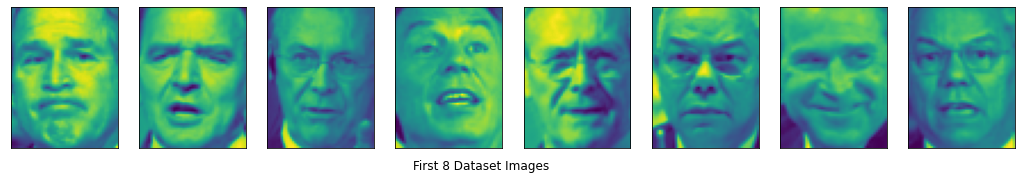

STATISTICS
Dataset has  1140 sample images
Each image is  62 x 47
Faces are of:
 ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [2]:
# Read the data
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)
# Get statistics of data
n_samples, r, c = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Display first 8 images of dataset
total_cols = 8
fig, ax = plt.subplots(nrows=1, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    ax[j].imshow(lfw_people.images[j, :, :])
plt.title('First 8 Dataset Images', y=-0.2, x=-4)    
plt.show()    

# Print statistics
print('STATISTICS')
print('Dataset has ', n_samples, 'sample images')
print('Each image is ', r, 'x', c)
print('Faces are of:\n', target_names)


### Prepare the Train and Test Data

The next step is to prepare the train and test data. The following steps are implemented in the code below:

1. Use `train_test_split()` method to split the dataset into a 75% training and 25% test set. 
1. Normalize each image's pixel values to lie between 0 and 1. As the grayscale images have pixel values between 0 and 255, we can divide each pixel value by 255 to normalize the entire image.
1. Use the `to_categorical()` method to convert each target value (range [0, 5]) to a 5 dimensional binary categorical vector.
1. Print the training and test data statistics

In [3]:
X = lfw_people.images
y = lfw_people.target
# Create train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(
                        X, y, test_size=0.25, random_state=0
                        )
# Normalize each image
train_X = train_X/255
test_X = test_X/255
# Create 5 dimensional binary indicator vectors
train_Y_categorical = utils.to_categorical(train_Y)
test_Y_categorical = utils.to_categorical(test_Y)
# Print statistics
print("Training data shape: ", train_X.shape)
print("Training categorical labels shape: ", train_Y_categorical.shape)
print("Test data shape: ", test_X.shape)
print("Test categorical labels shape: ", test_Y_categorical.shape)

Training data shape:  (855, 62, 47)
Training categorical labels shape:  (855, 5)
Test data shape:  (285, 62, 47)
Test categorical labels shape:  (285, 5)


## Create the Autoencoder Model

The code below shows how you can use the `Flatten`, `Dense` and `Reshape` layers to create an autoencoder model shown in Figure 2. The value of the `latent_dimension` is set at 420. You can experiment with different values of this variable. 

As we want the input images to match exactly the output images, we optimize with respect to the mean square error (`mse`). This can be specified as a parameter to the `compile()` method.

[Figure 2](https://drive.google.com/file/d/11EKDpUBamsHPSBuxAfeEUvDmQv8IXxfB/view?usp=sharing)

![The autoencoder model](autoencoderFigure2.jpg)
<p align = "center"> <b>Figure 2:</b> The Autoencoder Model With Layer Names Used in the Code</p>

In [4]:
latent_dimension = 420
input_shape = (train_X.shape[1], train_X.shape[2])
n_inputs = input_shape[0]*input_shape[1]
images = Input(shape=(input_shape[0], input_shape[1], ))
vector_images = Flatten()(images)
# encoder 
encoder_hidden = Dense(n_inputs/2, activation='relu')(vector_images)
latent = Dense(latent_dimension, activation='relu')(encoder_hidden)
# define decoder
decoder_hidden = Dense(n_inputs/2, activation='relu')(latent)
# output dense layer
decoder_output = Dense(n_inputs, activation='linear')(decoder_hidden)
output_images = Reshape((input_shape[0], input_shape[1], ))(decoder_output)
# define autoencoder model
autoencoder = Model(inputs=images, outputs=output_images)
# compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

Let's look at the summary of the autoencoder model we just built

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62, 47)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2914)              0         
_________________________________________________________________
dense (Dense)                (None, 1457)              4247155   
_________________________________________________________________
dense_1 (Dense)              (None, 420)               612360    
_________________________________________________________________
dense_2 (Dense)              (None, 1457)              613397    
_________________________________________________________________
dense_3 (Dense)              (None, 2914)              4248612   
_________________________________________________________________
reshape (Reshape)            (None, 62, 47)            0     

## Training the Autoencoder

Now we are ready to train the autoencoder model we just built. The `fit()` method below trains the model and returns a `history` object with details of the entire training process.

In [6]:
# fit the autoencoder model to reconstruct input
history = autoencoder.fit(train_X, train_X, epochs=100, validation_split=0.33)

Epoch 1/100
18/18 [==============================] - 1s 51ms/step - loss: 0.0802 - val_loss: 0.0219
Epoch 2/100
18/18 [==============================] - 1s 68ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 3/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0183 - val_loss: 0.0177
Epoch 4/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0171 - val_loss: 0.0159
Epoch 5/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 6/100
18/18 [==============================] - 1s 55ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 7/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/100
18/18 [==============================] - 1s 45ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 9/100
18/18 [==============================] - 1s 50ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 10/100
18/18 [==============================] - 1s 50ms/step - loss: 0.0109 - val_loss: 0.0109

18/18 [==============================] - 1s 50ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 83/100
18/18 [==============================] - 1s 56ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 84/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0073 - val_loss: 0.0081
Epoch 85/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 86/100
18/18 [==============================] - 1s 54ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 87/100
18/18 [==============================] - 1s 65ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 88/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 89/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 90/100
18/18 [==============================] - 1s 45ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 91/100
18/18 [==============================] - 1s 49ms/step - loss: 0.0034 - val_loss: 0.0051
Epo

We can visualize the entire learning process by using the values stored in the dictionary object of `history`. The following code prints the keys of the `history.history` dictionary object and plots the training and validation loss for each epoch. As expected, the value of the loss function for the training set is lower than the loss value for the validation set. 

Keys of history.history:  dict_keys(['loss', 'val_loss'])


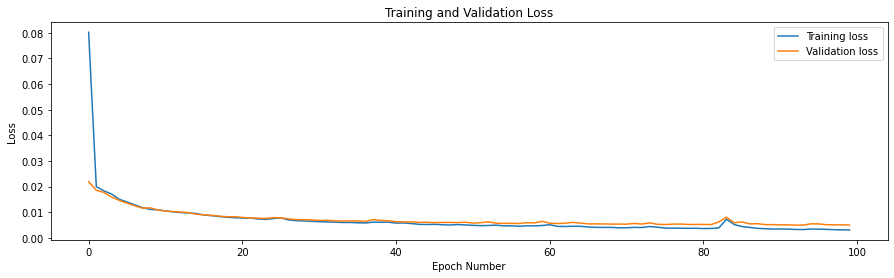

In [7]:
print('Keys of history.history: ', history.history.keys())

fig = plt.figure(figsize=(15,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

## Reconstructing the Input Images
After training the autoencoder, we can look at what the reconstructed input images look like. The `predict()` method returns the output of the autoencoder for the inputs specified as a parameter. The code below displays the first 8 images of the test set in the first row and their corresponding reconstructions in the second row.

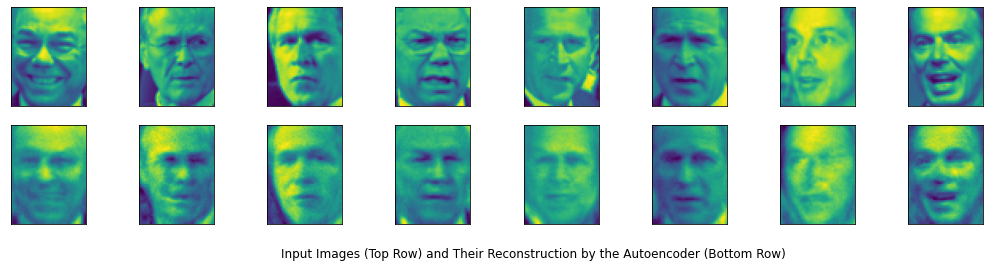

In [8]:
# Reconstruction
reconstructed_test = autoencoder.predict(test_X)
# Display the inputs and reconstructions
total_cols = 8
fig, ax = plt.subplots(nrows=2, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    ax[0, j].imshow(test_X[j, :, :])
    ax[1, j].imshow(reconstructed_test[j, :, :])
plt.title('Input Images (Top Row) and Their Reconstruction by the Autoencoder (Bottom Row)', y=-0.4, x=-5)    
plt.show()    

The reconstructed images are quite interesting. We can see that they are an approximation of the original images and closely replicate the facial expression of the input face. This makes them useful for augmenting a limited training set with more examples. You can generate as many images as needed by training the autoencoder multiple times. The reconstructed faces will vary with each run as the weights of the autoencoder are intialized randomly.

## Dissecting the Encoder

Tensorflow allows you to access the different layers of a model. We can easily retrieve the encoder block of the autoencoder by using the `Model()` method and instantiating it with the input `images` and output `latent` layer that we created earlier. Let's look at the summary of the encoder model.

In [9]:
# Encoder model
encoder_model = Model(inputs=images, outputs=latent)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62, 47)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2914)              0         
_________________________________________________________________
dense (Dense)                (None, 1457)              4247155   
_________________________________________________________________
dense_1 (Dense)              (None, 420)               612360    
Total params: 4,859,515
Trainable params: 4,859,515
Non-trainable params: 0
_________________________________________________________________


The summary shows that we started out with an input of `62*47=2914` pixels and reduced it to only `420` outputs. These 420 outputs are an internal/latent space representation of the corresponding input image. The output of the encoder is hard for us to interpret. However, we can give it a try and visualize it by displaying it as an image. The code below arbitrarily reshapes the latent representation to a 20x21 image and renders it. The top row shows the input training image and the bottom row shows the corresponding latent representation.

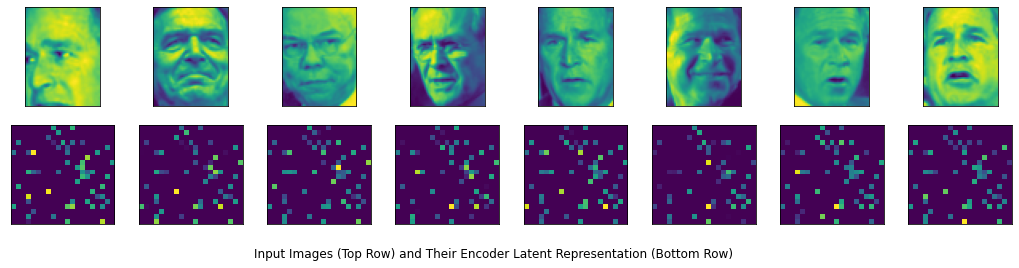

In [10]:
# Encoder output
encoder_output = encoder_model.predict(train_X)

latent_dim = encoder_output.shape[1]
latent_shape = (20,21)
# Plot the first 8 images and their corresponding latent representation
total_cols = 8
fig, ax = plt.subplots(nrows=2, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    train_image = train_X[j, :, :]
    ax[0, j].imshow(train_image)
    encoder_image = np.reshape(encoder_output[j, :], latent_shape)
    ax[1, j].imshow(encoder_image)
plt.title('Input Images (Top Row) and Their Encoder Latent Representation (Bottom Row)', y=-0.4, x=-4)    
plt.show()    

## Using the Autoencoder for Supervised Learning
Strictly speaking, an autoencoder is not a supervised learning model as it is trained with unlabeled images. However, we can use its latent representation to train a supervised learning model. The code below instantiates a `classifier` model by using all the layers of the autoencoder starting with the `vector_images` layer up to the `decoder_hidden` layer. It then appends the model with a `softmax` layer containing as many units as the number of classes/categories present in our dataset. 

In the `classifier` model, we'll set all the encoder layers to be non-trainable. This way the input image will be converted to its learned latent representation to be further processed by the classifier. The classifier will start training with the decoder weights tuned by the autoencoder and fine tune them further to learn the classification of each latent representation. Figure 3 shows a block diagram of the classifier created from the autoencoder model. Now that we have a multiclass classification problem, we can use the 'categorical_crossentropy' as our loss function when compiling the model.

[Figure 3](https://drive.google.com/file/d/1o5JTVUCjG4mY8g-RpWR31SOoKpVX3Za0/view?usp=sharing)
![The classifier model](autoencoderFigure3.jpg)
<p align = "center"> <b>Figure 3:</b> The Classifier Model Created From the Encoder </p>

In [11]:
# Create classifier model
classifier = Sequential()
label_layer = Dense(n_classes, activation='softmax')(decoder_hidden)
classifier = Model(inputs=images, outputs=label_layer)

# Set the encoder layers to non-trainable
for layer in classifier.layers[:-2]:
    layer.trainable=False

# Compile the model    
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Here is the summary of the classifier model. You can see that it has 620,687 trainable parameters associated with the last two layers. The rest of the weights uptil the encoder layer are non-trainable.

In [12]:
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62, 47)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2914)              0         
_________________________________________________________________
dense (Dense)                (None, 1457)              4247155   
_________________________________________________________________
dense_1 (Dense)              (None, 420)               612360    
_________________________________________________________________
dense_2 (Dense)              (None, 1457)              613397    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 7290      
Total params: 5,480,202
Trainable params: 620,687
Non-trainable params: 4,859,515
___________________________________________

Let's train the classifier using the `fit()` method.

In [13]:
history = classifier.fit(train_X, train_Y_categorical, epochs=150, validation_split=0.33)

Epoch 1/150
18/18 [==============================] - 1s 30ms/step - loss: 1.3415 - accuracy: 0.4668 - val_loss: 1.1846 - val_accuracy: 0.5300
Epoch 2/150
18/18 [==============================] - 0s 11ms/step - loss: 1.1362 - accuracy: 0.5559 - val_loss: 1.0383 - val_accuracy: 0.6113
Epoch 3/150
18/18 [==============================] - 0s 12ms/step - loss: 0.9913 - accuracy: 0.6084 - val_loss: 0.9970 - val_accuracy: 0.6784
Epoch 4/150
18/18 [==============================] - 0s 12ms/step - loss: 0.8902 - accuracy: 0.7028 - val_loss: 0.9639 - val_accuracy: 0.6396
Epoch 5/150
18/18 [==============================] - 0s 12ms/step - loss: 0.8480 - accuracy: 0.7063 - val_loss: 0.8832 - val_accuracy: 0.7527
Epoch 6/150
18/18 [==============================] - 0s 11ms/step - loss: 0.7661 - accuracy: 0.7535 - val_loss: 0.8163 - val_accuracy: 0.7208
Epoch 7/150
18/18 [==============================] - 0s 12ms/step - loss: 0.7111 - accuracy: 0.7465 - val_loss: 0.7681 - val_accuracy: 0.7951
Epoch 

18/18 [==============================] - 1s 32ms/step - loss: 0.1194 - accuracy: 0.9825 - val_loss: 0.5925 - val_accuracy: 0.8021
Epoch 59/150
18/18 [==============================] - 0s 22ms/step - loss: 0.1149 - accuracy: 0.9808 - val_loss: 0.6095 - val_accuracy: 0.8057
Epoch 60/150
18/18 [==============================] - 0s 19ms/step - loss: 0.1117 - accuracy: 0.9878 - val_loss: 0.6126 - val_accuracy: 0.8021
Epoch 61/150
18/18 [==============================] - 1s 30ms/step - loss: 0.1120 - accuracy: 0.9860 - val_loss: 0.6204 - val_accuracy: 0.8057
Epoch 62/150
18/18 [==============================] - 0s 15ms/step - loss: 0.1166 - accuracy: 0.9703 - val_loss: 0.6634 - val_accuracy: 0.7986
Epoch 63/150
18/18 [==============================] - 0s 12ms/step - loss: 0.1152 - accuracy: 0.9808 - val_loss: 0.6342 - val_accuracy: 0.8057
Epoch 64/150
18/18 [==============================] - 0s 13ms/step - loss: 0.1066 - accuracy: 0.9860 - val_loss: 0.6182 - val_accuracy: 0.7986
Epoch 65/150

18/18 [==============================] - 0s 12ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.7206 - val_accuracy: 0.7951
Epoch 116/150
18/18 [==============================] - 0s 14ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.7156 - val_accuracy: 0.7880
Epoch 117/150
18/18 [==============================] - 0s 16ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.7230 - val_accuracy: 0.7915
Epoch 118/150
18/18 [==============================] - 0s 16ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.7235 - val_accuracy: 0.7915
Epoch 119/150
18/18 [==============================] - 0s 23ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.7176 - val_accuracy: 0.7915
Epoch 120/150
18/18 [==============================] - 0s 16ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.7472 - val_accuracy: 0.7986
Epoch 121/150
18/18 [==============================] - 0s 17ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.7197 - val_accuracy: 0.7951
Epoch 

### Evaluate the Classifier
The code below prints the classification accuracy on the training and test sets. As this is a multiclass classification problem, it's good to observe the confusion matrix. While Tensorflow's math module provides a routine for computing the confusion matrix, we'll use the method provided by the scikit-learn's library. This library also includes a nice method for displaying the confusion matrix with fancy colors. We can see that we have a reasonably good accuracy on the face classification task without doing any preprocessing, hyper-parameter tuning and model selection.

In [14]:
train_loss, train_acc = classifier.evaluate(train_X,  train_Y_categorical)
test_loss, test_acc = classifier.evaluate(test_X,  test_Y_categorical)
print('Classification accuracy on training set: ', train_acc)
print('Classification accuracy on test set: ', test_acc)

9/9 [==============================] - 0s 7ms/step - loss: 0.5197 - accuracy: 0.8877
Classification accuracy on training set:  0.9286549687385559
Classification accuracy on test set:  0.8877192735671997


Correct classification:  253 / 285


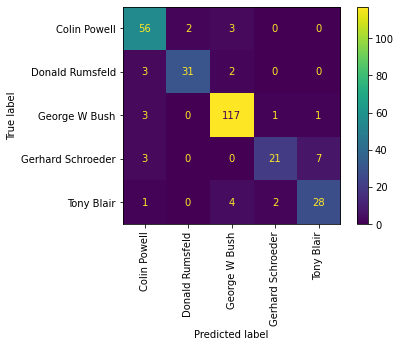

In [15]:
# Get the classifier outputs
test_predict = classifier.predict(test_X)
# Get the classification labels
test_predict_labels = np.argmax(test_predict, axis=1)
# Create and display the confusion matrix
test_confusion_matrix = confusion_matrix(test_Y, test_predict_labels)
cm = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, 
                       display_labels=target_names)

cm.plot(xticks_rotation="vertical")
print('Correct classification: ', np.sum(np.diagonal(test_confusion_matrix)), '/', test_X.shape[0])


## The Next Step
We just developed an autoencoder with an ability to create an approximation representation of its inputs. We also used its latent representation to develop a classifier and applied it to a face recognition problem. While this may not be the best example to demonstrate the merits of the autoencoder as a supervised classifier, it should give you a fairly good idea on how to implement an autoencoder model and use its latent space representation for other tasks. Now that you have a basic understanding of the autoencoder model, you can develop its more advanced and improved variants such as the variational autoencoder or the sparse autoencoder.